# EconML

We have downloaded the **Enquête emploi en continu 2015** database from the [INSEE website](https://www.insee.fr/fr/statistiques/2388681). The database is in dBASE format (`.dbf`, 80mb), compressed into a ZIP file (`.zip`, 9mb).

The `.zip` file contains three dBASE files:
   - `eec15.dbf` (77MB)
   - `varlist.dbf` (33KB)
   - `varmod.dbf` (33KB)

Because the dBASE format is inconvenient to work with, we import the contents of these three files into an SQLite databases using the [`dbf2sqlite`](https://github.com/olemb/dbfread/blob/master/examples/dbf2sqlite) script, with the following command:

    ./dbf2sqlite --encoding=cp850 -o ee-insee-2015.sqlite eec15.dbf varlist.dbf varmod.dbf

## Setup

### Libraries & Settings

In [1]:
import os              # General OS commands
import numpy as np     # NumPy
import pandas as pd    # Python Data Analysis Library
import sqlite3         # SQLite3 Database Driver

import matplotlib.pyplot as plt
# Display MatPlotLib stuff inline
%matplotlib inline     

In [2]:
# Never truncate columns, display all the data
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

### Helpers

In [3]:
# Helper function to display nice dictionaries in HTML
def HTMLIter(iter_):
    items = iter_ if isinstance(iter_, list) else iter_.iteritems()
    html = []
    for key, value in items:
        html.append("<tr>")
        html.append("<td><strong>{0}</strong></td>".format(key))
        html.append("<td>{0}</td>".format(value))
        html.append("</tr>")
    html.append("</table>")
    return HTML(''.join(html))

# Temporary files to delete at the end of the experiment
temp_files = []

### Database

The resulting SQLite database weighs about 89MB, which is too large for GitHub (our version control repository), so we compressed the database and decompress it on-the-fly before each experiment.

In [4]:
from zipfile import ZipFile
with ZipFile("data/ee-insee-2015-sqlite.zip") as zip_file:
    zip_file.extractall("data/")

eedb = "data/ee-insee-2015.sqlite"
temp_files.append(eedb)

## First look

### Variables
We first look at the list of variables to find out what kind of data we have access to. The variables (i.e. the columns of the main table `eec15`) and their labels are stored in the `varlist` table.

In [5]:
with sqlite3.connect(eedb) as con:
    query = "SELECT * FROM varlist"
    df = pd.read_sql_query(query, con)

df.columns = ["Variable", "Libellé"]
HTML(df.to_html(index=False))

Variable,Libellé
AAC,"Exercice d'une activité professionnelle régulière antérieure, pour les inactifs, chômeurs et personnes ayant une activité temporaire ou d'appoint autre qu'un emploi informel"
ACTEU,Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire
ACTEU6,Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire (6 postes)
ACTIF,Actif au sens du BIT
ACTOP,Actif occupé au sens du Bureau International du Travail (BIT)
AGE3,"Âge au dernier jour de la semaine de référence (3 postes, premier type de regroupement)"
AGE5,Âge au dernier jour de la semaine de référence (5 postes)
AIDFAM,Aide familial ou conjoint collaborateur
ANCCHOM,Ancienneté de chômage en 8 postes
ANCENTR4,Ancienneté dans l'entreprise ou dans la fonction publique (4 postes)


### Survey Data
We first load the `eec15` table into a `pandas` DataFrame for easier manipulation.

In [6]:
with sqlite3.connect(eedb) as con:
    eec15 = pd.read_sql("SELECT * FROM eec15", con)

We look at the actual survey data to get an idea of how much data we are dealing with, and what this data looks like.

In [7]:
HTMLIter([
    ("Observations: ", eec15.shape[0]),
    ("    Men: ", eec15[eec15.sexe == "1"].shape[0]),
    ("    Women: ", eec15[eec15.sexe == "2"].shape[0]),
    ("Parameters: ", eec15.shape[1])
])

Observations:,431678
Men:,203516
Women:,228162
Parameters:,125


In [8]:
eec15.head()

,annee,trim,catau2010r,metrodom,typmen7,age3,age5,coured,enfred,nfrred,...,dip11,cstotprm,identm,extrian16,empnbh,hrec,hhce,hplusa,jourtr,nbtote
0,2015,2,1,1,4,30,30,1,1,1,...,71,53,1,127.083178,37.0,NaN,37.0,NaN,5.0,NaN
1,2015,2,1,1,4,15,15,1,1,1,...,42,53,1,127.083178,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,2,1,1,1,15,15,2,2,1,...,10,54,2,133.254104,NaN,NaN,36.0,NaN,5.0,NaN
3,2015,3,1,1,1,15,15,2,2,1,...,10,54,3,141.969987,NaN,NaN,36.0,39.0,5.0,NaN
4,2015,4,1,1,1,15,15,2,2,1,...,10,54,4,136.181683,36.0,NaN,36.0,40.0,5.0,NaN


## Variable description
As our objective is to model employment/unemployment, we take a deeper look into the variables that are available to us. In particular, we identify some variables of interest that we believe would be appropriate parameters in a regression model.

We then try to summarise these variables through (1) **descriptive statistics** (2) **graphical representation**, which gives us better insights into the variables and what they look like.

### Dependent/explained variable
The objective of our model will be to identify the relationship between **employment status** and some parameters that we will choose from the set of variables in the database. As such, the regressor in our model will be a binary variable **employed/unemployed**.

The database provides us with the following data, so we need to figure out which of these is closest to a simple employed/unemployed binary variable:
- **ACTEU**: *Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire*
- **ACTEU6**: *Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire (6 postes)*
- **ACTIF**: *Actif au sens du BIT*
- **ACTOP**: *Actif occupé au sens du BIT*

The possible values for these variables are contained in the `varmod` table and are summarised in the following table (*for simplicity, we choose to ignore **ACTEU6***).

In [9]:
with sqlite3.connect(eedb) as con:
    query = """
        SELECT *
        FROM varmod
        WHERE variable IN ("ACTEU", "ACTIF", "ACTOP")
    """
    df = pd.read_sql_query(query, con)

df.columns = ["Variable", "Modalité", "Libellé"]
HTML(df.to_html(index=False))

Variable,Modalité,Libellé
ACTEU,,"Sans objet (ACTEU non renseigné, individus de 15 ans et plus nécessairement non pondérés)"
ACTEU,1,Actif occupé
ACTEU,2,Chômeur
ACTEU,3,Inactif
ACTIF,,"Sans objet (ACTEU non renseigné, individus de 15 ans et plus nécessairement non pondérés)"
ACTIF,1,Actif
ACTIF,2,Inactif
ACTOP,,"Sans objet (ACTEU non renseigné, individus de 15 ans et plus nécessairement non pondérés)"
ACTOP,1,Oui
ACTOP,2,Non


We can take the opportunity to perform a **sanity check** on the data, to ensure both that the data is consistent, and that we have understood these variables properly. To this end, we use the following identities, inferred from the definitions of the variables contained in the `varlist`/`varmod` tables:
- `ACTOP(1) = ACTEU(1)`
- `ACTOP(2) = ACTEU(2) + ACTEU(3)`
- `ACTIF(1) = ACTEU(1) + ACTEU(2)`
- `ACTIF(2) = ACTEU(3)`

In [10]:
varmods = [("ACTEU", [1, 2, 3]), ("ACTOP", [1, 2]), ("ACTIF", [1, 2])]
varmods = [(v[0], m) for v in varmods for m in v[1]]
counts = {vm: eec15[eec15[vm[0].lower()] == str(vm[1])].shape[0] for vm in varmods}
        
print "ACTOP(1): {} | ACTEU(1): {}".format(counts[("ACTOP", 1)], counts[("ACTEU", 1)])
print "ACTOP(2): {} | ACTEU(2) + ACTEU(3): {}".format(counts[("ACTOP", 2)], sum([counts[("ACTEU", 2)], counts[("ACTEU", 3)]]))
print "ACTIF(1): {} | ACTEU(1) + ACTEU(2): {}".format(counts[("ACTIF", 1)], sum([counts[("ACTEU", 1)], counts[("ACTEU", 2)]]))
print "ACTIF(2): {} | ACTEU(3): {}".format(counts[("ACTIF", 2)], counts[("ACTEU", 3)])

ACTOP(1): 198381 | ACTEU(1): 198379
ACTOP(2): 231995 | ACTEU(2) + ACTEU(3): 231997
ACTIF(1): 223130 | ACTEU(1) + ACTEU(2): 223130
ACTIF(2): 207246 | ACTEU(3): 207246


The sanity check has highlighted some very slight discrepancies. The (small) difference in totals does not *necessarily* mean that only 2 observations are affected: we need to check how many rows are affected and whether this discrepancy can turn out to be problematic.

In [11]:
# Filter the DataFrame to find the problematic rows
masks = [
    (eec15.actop == "1") & (eec15.acteu != "1"),
    (eec15.acteu.isin(["2", "3"]) & ~(eec15.actop == "2"))
]

# Print the index of problematic observations
obs = [list(eec15[mask].index) for mask in masks]
print obs

[[213788, 244700], [213788, 244700]]


The (two) affected rows are the same for both masks, so we can safely conclude that these two observations are problematic, but that the rest of the database is safe. We also remove these two observations from the DataFrame for later analyses.

In [12]:
eec15 = eec15[~eec15.index.isin(obs[0])]

The results of our sanity check are now satisfactory, we choose to use **ACTOP** as our (binary) dependent variable:
- **ACTOP = 1**: the observed individual is part of the *population active occupée*
- **ACTOP = 2**: the observed individual is *chômeur* or *inactif*

### Independent/explanatory variables
We choose a few "basic" variables that we (intuitively) think will be part of our regression models:
- **AGE5**: *Âge au dernier jour de la semaine de référence (5 postes)*
- **DIP11**: *Diplôme le plus élevé obtenu (2 chiffres, 11 postes)*
- **SEXE**: *Masculin/Féminin*

In [13]:
basic = eec15[["actop", "age5", "dip11", "sexe"]].copy()    # create a new df subset of the entire database
basic = basic.replace([""], [None]).dropna()    # drop any rows that have null/empty values
for col in ["actop", "sexe"]:
    basic[col] = basic[col].map({"2": 1, "1": 0})
basic = basic.astype(int)    # convert all data to float()

We now look at summary statistics and graphical representations for these variables.

In [14]:
basic.describe()

,actop,age5,dip11,sexe
count,427080.000000,427080.000000,427080.000000,427080.000000
mean,0.537578,42.270781,47.867629,0.529414
std,0.498586,16.780730,19.542119,0.499135
min,0.000000,15.000000,10.000000,0.000000
25%,0.000000,30.000000,41.000000,0.000000
50%,1.000000,50.000000,50.000000,1.000000
75%,1.000000,60.000000,70.000000,1.000000
max,1.000000,60.000000,71.000000,1.000000


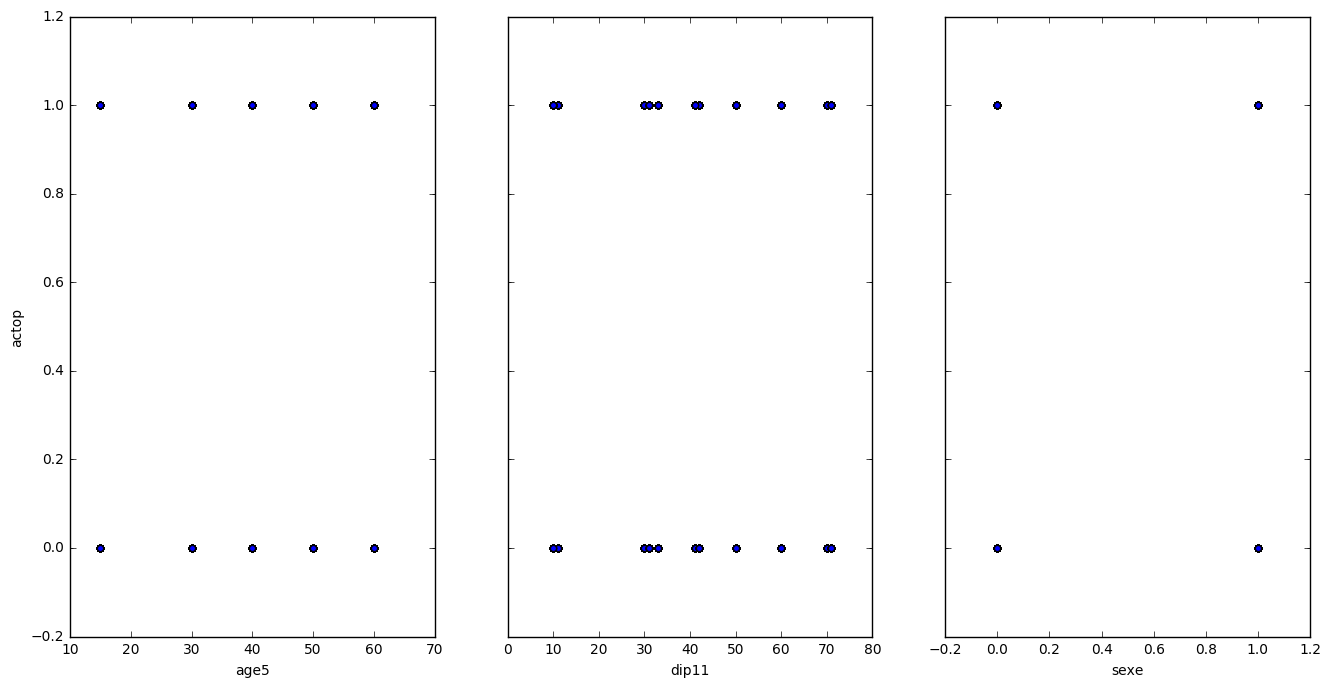

In [15]:
# visualize the relationship between the features and the response using scatterplots
figure, x_axis = plt.subplots(1, 3, sharey=True)
df.plot(kind="scatter", x="age5", y="actop", ax=x_axis[0], figsize=(16, 8))
df.plot(kind="scatter", x="dip11", y="actop", ax=x_axis[1])
df.plot(kind="scatter", x="sexe", y="actop", ax=x_axis[2])

## Basic Linear Regressions
We now turn to basic linear regressions:
- **dependent variable**: `ACTOP`
- **independent variables**: `AGE5`, `DIP11`, `SEXE`

In [10]:
# Connect to database and load the data we need into a dataframe
with sqlite3.connect(eedb) as con:
    query = "SELECT actop, age5, dip11, sexe FROM eec15"
    df = pd.read_sql_query(query, con)
    
# Refactor the data in the format we need for regressions
# In particular, convert categorical variables into dummy variables

## ACTOP: drop NULL, map ('1', '2') -> (0, 1)
df = df[df.actop != ""]
df["actop"] = df["actop"].map({'1': 0, '2': 1})

## AGE5: split into AGE{15,30,40,50} columns (ignore "00" and "60")
df = df[df.age5 != ""]
df.age5 = df.age5.astype(int)
for x in list(set(df["age5"].get_values())):
    df["age{}".format(x)] = np.where(df["age5"] == x, 1, 0)
    
## DIP11: group/split into DIP{0,1,3,4,5,6,7}
df = df[df.dip11 != ""]
df.dip11 = df.dip11.astype(int)
for x in list(set(df["dip11"].get_values())):
    df["dip{}".format(x)] = np.where(df["dip11"] == x, 1, 0)

## SEXE
df["female"] = df["sexe"].map({'1': 0, '2': 1})

df.head()

,actop,age5,dip11,sexe,age40,age50,age60,age30,age15,dip33,dip70,dip71,dip41,dip42,dip50,dip60,dip10,dip30,dip31,female
0,0,30,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,1,15,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,0,15,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,15,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,15,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Logistic Regressions (`logit`)

In [11]:
import statsmodels.api as sm

# Get rid of data we don't need in the regression
df = df[df.age60 == 0]

# https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
female = ["female"]
age = ["age{}".format(x) for x in ["15", "30", "40", "50"][:-1]] # ignore 50 (dummy variable trap) and 60 (no data)
# diploma = ["dip{}".format(x) for x in ["10", "11", "30", "31", "33", "41", "42", "50", "60", "70", "71"][:-1]] # careful with dip11 (same name as original column)
X = female + age #+ diploma
X = df[X]
y = df["actop"]
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  actop   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                 1.320e+04
Date:                Thu, 12 Jan 2017   Prob (F-statistic):               0.00
Time:                        20:10:02   Log-Likelihood:            -1.6775e+05
No. Observations:              283565   AIC:                         3.355e+05
Df Residuals:                  283560   BIC:                         3.356e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2211      0.002    121.350      0.000         0.217     0.225
female         0.0796      0.002     48.425      0.000         0.076     0.083
age15          0.3701      0.002    167.548      0.000         0.366     0.374
age30         -0.0335      0.002    -13.637      0.000        -0.038    -0.029
age40         -0.0680      0.002    -29.568      0.000        -0.073    -0.064
==============================================================================
Omnibus:                    46837.465   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23800.935
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                       2.129   Cond. No.                         5.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Cleanup

Now that the experiments have concluded, we delete all the "temporary" files.

In [12]:
for temp in temp_files:
    os.remove(temp)